# Using `ROMS-Tools` with `Dask`

This notebook aims to:

* Explain how to use `ROMS-Tools` with `Dask`
* Identify when `Dask` is beneficial for `ROMS-Tools` workflows
* Demonstrate different `Dask` deployment options
* Explain the validation process and how to bypass it for performance optimization

## How to use `ROMS-Tools` with `Dask`

[Dask](https://www.dask.org/) is a Python parallel computing library that enables scalable, out-of-memory data processing by distributing computations across multiple threads or processes. 
`ROMS-Tools` integrates with `Dask` for several key classes where handling large datasets efficiently is essential:

1. tidal forcing: `TidalForcing`
2. surface forcing: `SurfaceForcing`
3. boundary forcing: `BoundaryForcing`
4. initial conditions: `InitialConditions`
5. ROMS output: `ROMSOutput`

Each of these classes can be used with or without `Dask`, controlled by the `use_dask` parameter. By default, `use_dask` is set to `False`, primarily because `Dask` is an optional dependency, and not all users may have it installed. However, enabling `use_dask = True` is essential for preventing memory issues and speeding up computations when working with large datasets. We will discuss *when* to use `Dask` in [this section](https://roms-tools.readthedocs.io/en/latest/using_dask.html#When-To-Use-Dask?) below, but first, let's go over *how* to use `Dask` with `ROMS-Tools`.

Let's explore an example using the following grid:

In [1]:
from roms_tools import Grid, InitialConditions
from datetime import datetime

In [2]:
grid = Grid(
    nx=500, ny=500, size_x=1000, size_y=1000, center_lon=-20, center_lat=65, rot=0
)

In the following example, we set up initial conditions (with BGC) using the `InitialConditions` class, first without `Dask` and then with `Dask`. While the resulting data will be identical, the key distinction is in how the computations are performed.

Let's work with the following fixed parameters:

In [3]:
initial_conditions_parameters = {
    "grid": grid,
    "ini_time": datetime(2012, 1, 2),
    "allow_flex_time": True,
    "source": {
        "name": "GLORYS",
        "path": "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc",
    },
    "bgc_source": {
        "name": "CESM_REGRIDDED",
        "path": "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc",
        "climatology": True,
    },
}

In [4]:
%load_ext memory_profiler

### Without Dask (`use_dask = False`)

* Computations run serially (not parallelized).
* Computations occur during class initialization, meaning object creation takes longer.
* The `.ds` attribute holds eagerly evaluated data.
* The `.plot()` and `.save()` methods execute quickly since the data is already computed.

In [5]:
%%time
%%memit

initial_conditions_without_dask = InitialConditions(
    **initial_conditions_parameters, use_dask=False
)

2026-01-14 14:02:36 - WARNING - Selected time entry closest to the specified start_time in +24 hour range: ['2012-01-02T12:00:00.000000000']


peak memory: 15506.66 MiB, increment: 15051.04 MiB
CPU times: user 5min 9s, sys: 7.1 s, total: 5min 16s
Wall time: 39.8 s


As seen in the summary above, initialization took about 40 seconds and consumed ~15GB of memory (this was on a compute node on [Perlmutter](https://docs.nersc.gov/systems/perlmutter/architecture/)).

We can confirm this by inspecting the `.ds` attribute, which holds an xarray Dataset. As expected, all data arrays are eagerly evaluated, meaning they are fully loaded into memory rather than being computed lazily.

In [6]:
initial_conditions_without_dask.ds

<xarray.Dataset> Size: 4GB
Dimensions:      (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                  xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB 4.769 ......
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB 35.09 ......
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 101MB -0.09013 .....
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 101MB -0.05543 .....
    zeta         (ocean_time, eta_rho, xi_rho) float32 1MB -0.7428 ... -0.8718
    ubar         (ocean_time, eta_rho, xi_u) float32 1MB -0.0559 ... 0.007278
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB -3.605e-0...
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB 0.0008413...
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB 0.284 ......
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   3.1.2.dev23+gc2b82bc5c
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           CESM_REGRIDDED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

Since the data has already been computed, both plotting and saving are nearly instantaneous and require minimal additional memory. The next two cells demonstrate this.

peak memory: 5360.57 MiB, increment: 118.68 MiB
CPU times: user 347 ms, sys: 92.9 ms, total: 440 ms
Wall time: 570 ms


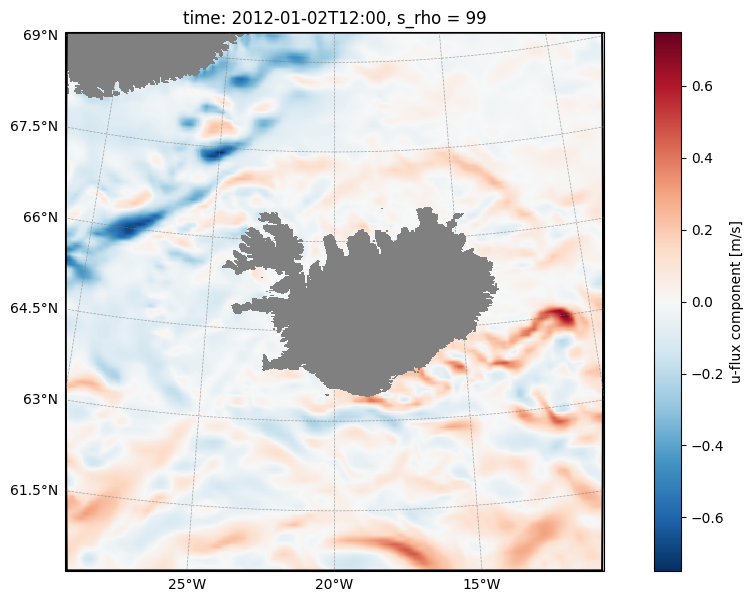

In [6]:
%%time
%%memit

initial_conditions_without_dask.plot("u", s=-1)

In [7]:
filename = "/pscratch/sd/n/nloose/forcing/my_initial_conditions.nc"

In [8]:
%%time
%%memit

initial_conditions_without_dask.save(filename)

2026-01-14 14:03:54 - INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_initial_conditions.nc


peak memory: 5367.93 MiB, increment: 96.70 MiB
CPU times: user 1.59 s, sys: 4.89 s, total: 6.48 s
Wall time: 6.64 s


### With Dask (`use_dask = True`)

* Computations are parallelized using `Dask`.
* Computations are delayed until `.plot()` or `.save()` is called (except for a few variables used for validation), meaning object creation is faster.
* The `.ds` attribute holds lazy (unevaluated) data.
* The `.plot()` and `.save()` methods take longer to run, as computations occur at this stage.

In [9]:
%%time
%%memit

initial_conditions_with_dask = InitialConditions(
    **initial_conditions_parameters, use_dask=True
)

2026-01-14 14:04:01 - WARNING - Selected time entry closest to the specified start_time in +24 hour range: ['2012-01-02T12:00:00.000000000']


peak memory: 14603.70 MiB, increment: 9331.86 MiB
CPU times: user 2min 18s, sys: 4.25 s, total: 2min 22s
Wall time: 23.8 s


As seen in the summary above, initialization was faster and consumed less memory compared to `use_dask = False` (see the wall time and memory increment metrics), reducing the wall time to 23 seconds and cutting memory usage from 15GB to 9GB. This is because computations are deferred until explicitly triggered, rather than being performed immediately upon initialization. 

As a result, the `.ds` attribute holds an xarray Dataset with lazy data arrays, meaning the actual computations occur only when needed, such as during plotting or saving. However, certain variables are exceptions and are computed eagerly:

* `w` is set to zero and stored eagerly.
* `Cs_r` and `Cs_w` are copied from `grid.ds`, where they were originally stored eagerly.
* `zeta` is computed eagerly to check for NaNs in the interpolated field during validation.
* `ALK` is also computed eagerly for NaN validation. As a 3D field, it significantly contributes to the high memory footprint (28GB) during initialization.

We will explore the validation step further in [this section](https://roms-tools.readthedocs.io/en/latest/using_dask.html#Bypassing-validation) later on.

In [10]:
initial_conditions_with_dask.ds

<xarray.Dataset> Size: 4GB
Dimensions:      (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                  xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    zeta         (ocean_time, eta_rho, xi_rho) float32 1MB -0.7428 ... -0.8718
    ubar         (ocean_time, eta_rho, xi_u) float32 1MB dask.array<chunksize=(1, 409, 409), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   3.1.2.dev23+gc2b82bc5c
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           CESM_REGRIDDED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

Plotting triggers the computation of the requested variable, which results in non-negligible compute time and memory usage. 

[########################################] | 100% Completed | 2.34 sms
peak memory: 14671.22 MiB, increment: 587.56 MiB
CPU times: user 2min 32s, sys: 1.46 s, total: 2min 34s
Wall time: 2.89 s


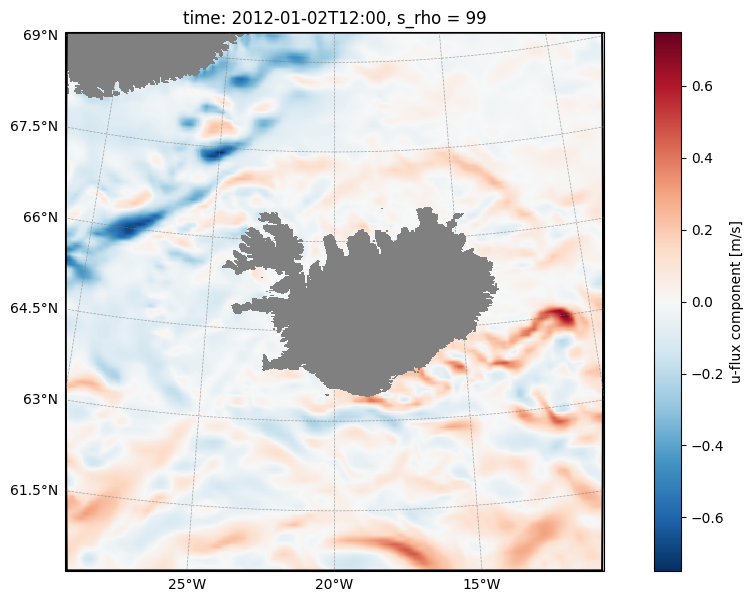

In [11]:
%%time
%%memit

initial_conditions_with_dask.plot("u", s=-1)

Saving triggers the computation of the entire dataset. 

In [12]:
%%time
%%memit

initial_conditions_with_dask.save(filename)

2026-01-14 14:05:14 - INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_initial_conditions.nc


[########################################] | 100% Completed | 18.74 s
peak memory: 30626.43 MiB, increment: 16437.92 MiB
CPU times: user 19min 54s, sys: 26.9 s, total: 20min 21s
Wall time: 20.5 s


Finally, we confirm that the two datasets that were created are identical.

In [13]:
initial_conditions_with_dask.ds.identical(initial_conditions_without_dask.ds)

True

## When To Use `Dask`?

<div class="alert alert-info">

General Rule

We recommend enabling `Dask` (`use_dask = True`) for all five classes in `ROMS-Tools` that integrate with Dask (listed at the top of this notebook), unless you're working with very small test domains. 

</div>

Note that for tidal forcing (`TidalForcing`) you may not see a significant benefit from using `Dask`, as the computations are generally fast and have a low memory footprint. In such cases, using `Dask` might introduce more overhead than it provides benefit. However, the performance difference is usually minimal (we're talking a few seconds).
    
Below, we highlight three scenarios where enabling `Dask` is crucial. These cover the majority of use cases.

### 1. Large Input Datasets

Working with large input datasets (e.g., ERA5 or GLORYS) can lead to high memory usage if `use_dask = False`, particularly when dealing with global-scale data **spanning many time slices (months to years)**. This is especially relevant for `SurfaceForcing` and `BoundaryForcing`, where many time slices may need to be loaded at once. Some more context is given [here](https://github.com/CWorthy-ocean/roms-tools/issues/213). For reference, here’s an example of the storage requirements for one year of ERA5 and GLORYS data, even when restricted to the North Atlantic:

In [26]:
!du -hs /global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/
!du -hs /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/

11G	/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/
60G	/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/


### 2. Large Output Datasets
In some cases, the dataset stored in the `.ds` attribute is inherently large and may not fit into memory. This is particularly relevant for `SurfaceForcing` and `BoundaryForcing`, where the processed dataset can be extensive due to long time periods and high-resolution grids. When working with large output datasets, enabling Dask (`use_dask = True`) is crucial to avoid memory overflow. Below is an example of how much memory the output dataset requires for one year of ERA5 data on a medium-sized grid.

In [2]:
from roms_tools import SurfaceForcing

In [3]:
surface_forcing_parameters = {
    "grid": Grid(
        nx=1000, ny=1000, size_x=1000, size_y=1000, center_lon=-20, center_lat=65, rot=0
    ),
    "start_time": datetime(2012, 1, 1),
    "end_time": datetime(2012, 12, 31),
    "source": {
        "name": "ERA5",
        "path": "/global/cfs/projectdirs/m4746/Datasets/ERA5/NA/2012/ERA5*.nc",
    },
}

In [4]:
surface_forcing = SurfaceForcing(
    **surface_forcing_parameters,
    use_dask=True,
)

print(f"Memory footprint of output dataset: {surface_forcing.ds.nbytes / 1e6:.2f} MB")

INFO - Data will be interpolated onto grid coarsened by factor 2.


Memory footprint of output dataset: 61818.74 MB


Note that the output dataset requires 61 GB, which is more memory than the input dataset (which was 11GB). This can happen when working with high-resolution grids, where regridding increase the dataset size beyond the original input.

### 3. Memory-Intensive Intermediate Computations
Even if neither large input datasets nor large output datasets are an issue, certain intermediate operations can still be highly memory-intensive. Memory failures can be prevented with `use_dask = True`.

## `Dask` Deployment Options
`Dask` can be deployed in different ways within `ROMS-Tools`, using either a single-machine scheduler or a distributed scheduler. For more details, refer to the [Dask scheduling documentation](https://docs.dask.org/en/stable/scheduling.html).

Deployment modes:

* **Single-Machine**: Uses only threads within a single process.
* **Distributed**: Utilizes a combination of threads and processes or spans multiple nodes.

Below, we provide an example of a **single-machine** deployment on a Perlmutter compute node. To set this up, add the following at the beginning of your notebook:

In [5]:
import dask

dask.config.set(
    scheduler="threads",  # Use multi-threading
    n_workers=10,  # Number of threads; adjust as needed
)

<div class="alert alert-info">

Note

The single-machine threaded scheduler is the default in Dask, with an automatically determined number of threads. Therefore, if you don't explicitly configure the scheduler at the top of your notebook, Dask will use this default setup.

</div>

After this, you can proceed to create and save the surface forcing as usual.

In [6]:
surface_forcing = SurfaceForcing(**surface_forcing_parameters, use_dask=True)

INFO - Data will be interpolated onto grid coarsened by factor 2.


In [9]:
%%time
%%memit

surface_forcing.save("/pscratch/sd/n/nloose/forcing/my_surface_forcing.nc")

INFO - Writing the following NetCDF files:
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201201.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201202.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201203.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201204.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201205.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201206.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201207.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201208.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201209.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201210.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201211.nc
/pscratch/sd/n/nloose/forcing/my_surface_forcing_201212.nc


[########################################] | 100% Completed | 118.35 s
[########################################] | 100% Completed | 107.29 s
[########################################] | 100% Completed | 134.23 s
[########################################] | 100% Completed | 117.67 s
[########################################] | 100% Completed | 128.52 s
[########################################] | 100% Completed | 110.14 s
[########################################] | 100% Completed | 114.62 s
[########################################] | 100% Completed | 120.22 s
[########################################] | 100% Completed | 110.98 s
[########################################] | 100% Completed | 116.81 s
[########################################] | 100% Completed | 112.20 s
[########################################] | 100% Completed | 115.31 s
peak memory: 14887.32 MiB, increment: 12609.81 MiB
CPU times: user 1d 20h 53min 30s, sys: 4min 37s, total: 1d 20h 58min 7s
Wall time: 25min 40s


To set up a distributed deployment in Dask, add the following at the top of your notebook:

```
from dask.distributed import Client
client = Client()  # Create a distributed Dask cluster, configure as needed
client
```

This will initialize a distributed Dask cluster, allowing Dask to distribute tasks across multiple processes or nodes. You can customize the cluster's configuration by passing additional options to `Cluster()` as required for your environment.

Next, create and save ROMS-Tools objects as usual. From experience, the single-machine threaded scheduler tends to perform better on most machines with `ROMS-Tools`. However, the choice of scheduler will ultimately depend on your system's resources and the specific problem you're solving.

## Bypassing validation

By default, `ROMS-Tools` classes perform a validation step during initialization to ensure the source data adequately covers the grid, particularly in the horizontal direction. In practice, this validation step detects NaNs after regridding. 

You can disable validation by setting `bypass_validation = True` (default: `False`), but **this is not recommended**. Skipping validation means missing crucial checks, such as verifying full grid coverage and detecting NaNs—values that would otherwise be replaced with a fill value, potentially leading to incorrect model results.

Nevertheless, the following classes support the `bypass_validation` parameter:

* `TidalForcing`
* `SurfaceForcing`
* `BoundaryForcing`
* `InitialConditions`
  

**Important Considerations**:

* If `use_dask = False`, skipping validation **does not** improve performance, as data is computed during initialization regardless. Setting `bypass_validation = True` offers no benefit.
* If `use_dask = True`, skipping validation can speed up initialization and reduce memory usage. If you are confident that your source datasets (e.g., global datasets) fully cover the domain, you may set `bypass_validation = True`. However, this does not affect the `.save()` stage.

In the previous example, initializing conditions with BGC required a full 3D NaN check of ALK. The following example demonstrates the same setup but with `use_dask = True` and validation bypassed.

In [14]:
%%time
%%memit

initial_conditions_with_dask_and_bypassed_validation = InitialConditions(
    **initial_conditions_parameters, use_dask=True, bypass_validation=True
)

2026-01-14 14:07:51 - WARNING - Selected time entry closest to the specified start_time in +24 hour range: ['2012-01-02T12:00:00.000000000']


peak memory: 29562.40 MiB, increment: 8797.66 MiB
CPU times: user 2min 4s, sys: 7.41 s, total: 2min 11s
Wall time: 25.7 s


In this example, the initialization process takes approximately the same time, and the memory footprint is slightly reduced. The `.ds` attribute contains genuinely lazy-loaded data, including variables like `zeta` and `ALK`, which are only computed when accessed.

In [16]:
initial_conditions_with_dask_and_bypassed_validation.ds

<xarray.Dataset> Size: 4GB
Dimensions:      (ocean_time: 1, s_rho: 100, eta_rho: 502, xi_rho: 502,
                  xi_u: 501, eta_v: 501, s_w: 101)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-02T12:00:00
  * ocean_time   (ocean_time) float64 8B 3.788e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    zeta         (ocean_time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 502, 502), meta=np.ndarray>
    ubar         (ocean_time, eta_rho, xi_u) float32 1MB dask.array<chunksize=(1, 409, 409), meta=np.ndarray>
    ...           ...
    diazFe       (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    spCaCO3      (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    zooC         (ocean_time, s_rho, eta_rho, xi_rho) float32 101MB dask.array<chunksize=(1, 100, 409, 409), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 102MB 0.0 ... 0.0
    Cs_r         (s_rho) float32 400B -0.992 -0.9753 ... -8.89e-05 -9.874e-06
    Cs_w         (s_w) float32 404B -1.0 -0.9837 -0.9667 ... -3.95e-05 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   3.1.2.dev23+gc2b82bc5c
    ini_time:                             2012-01-02 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           CESM_REGRIDDED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

<div class="alert alert-info">

Summary

To reiterate, setting `bypass_validation = True` is not recommended unless you're debugging or are absolutely certain that your dataset fully covers the ROMS domain. Even then, performing a NaN check is still a valuable sanity check.

</div>